In [48]:
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
from models.UNet.UNet import UNet
sys.path.insert(0, '../shared/')
from data_generator import DataGenerator
from predict import Predict

In [50]:
json_file = open('../config/config.json')
data = json.load(json_file)

# Splits training and testing data then gets corresponding files based on similar file names
dataset_path = data['DATASET_PATH'] + 'Fog/'

validation_rgb = list(Path(dataset_path + 'RGB/Fog_Validation').glob('*.png'))
validation_annotated = list(Path(dataset_path + 'Annotated/Validation').glob('*_gt_labelColor.png'))

# Splits training and testing data then gets corresponding files based on similar file names
training_rgb, test_rgb = train_test_split(list(Path(dataset_path + 'RGB/Fog_Train').glob('*.png')), test_size=0.1)
training_annotated = [y for x in training_rgb for y in
                      list(Path(dataset_path + 'Annotated/Train').glob('*_gt_labelColor.png'))
                      if x.name.strip('_rgb_anon.png') == y.name.strip('_gt_labelColor.png')]
test_annotated = [y for x in test_rgb for y in list(Path(dataset_path + 'Annotated/Train').glob('*_gt_labelColor.png'))
                  if x.name.strip('_rgb_anon.png') == y.name.strip('_gt_labelColor.png')]

In [31]:
# [(image, annotated image)]
training_duo = [(x, y) for x, y in zip(training_rgb, training_annotated)]
testing_duo = [(x, y) for x, y in zip(test_rgb, test_annotated)]
validation_duo = [(x, y) for x, y in zip(validation_rgb, validation_annotated)]
image_size = (256, 256)

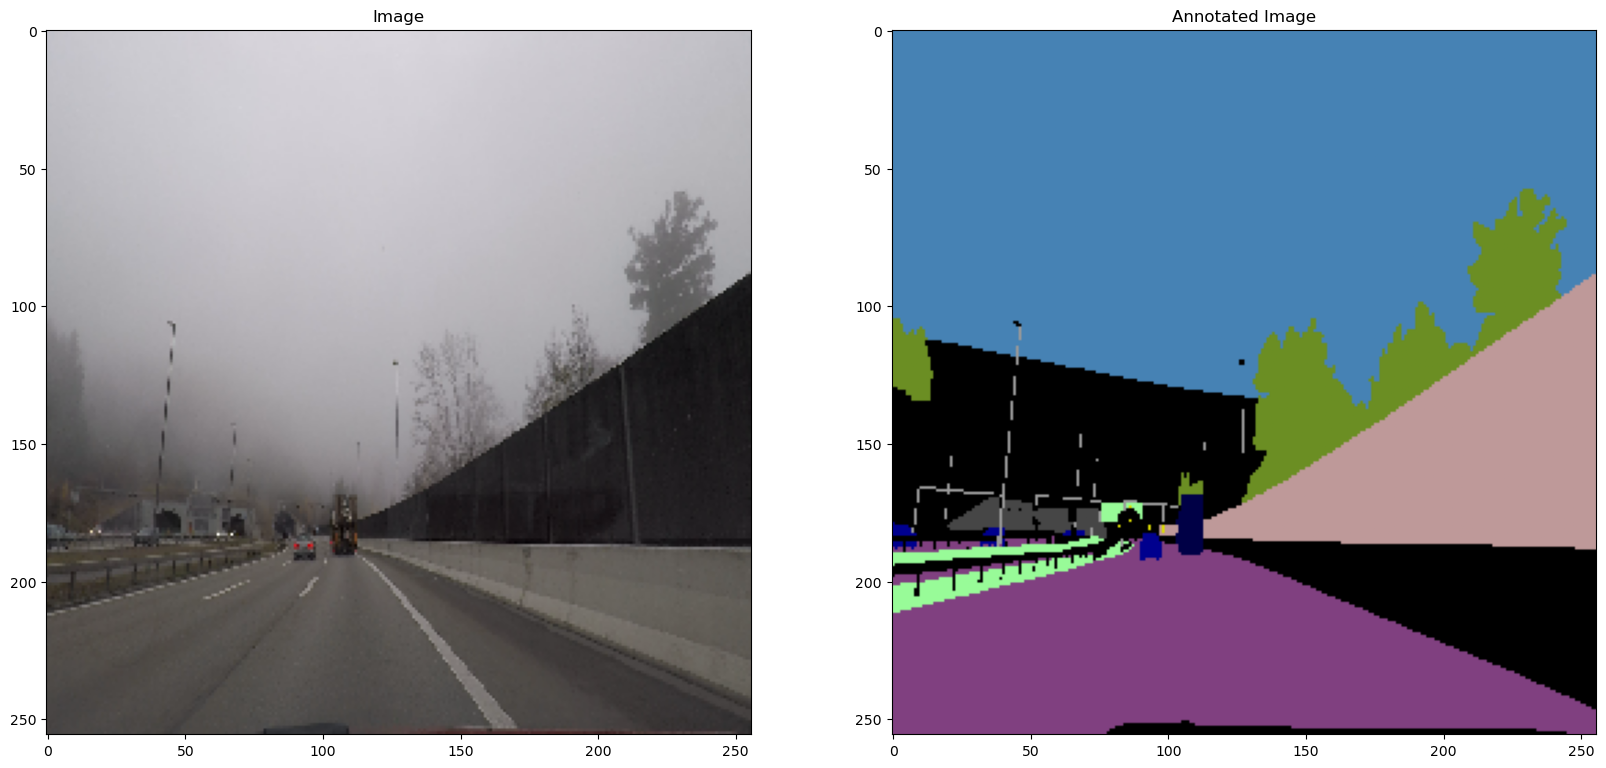

In [32]:
random_duo = training_duo[0]
image = img_to_array(load_img(random_duo[0], target_size=image_size))
annotated_image = img_to_array(load_img(random_duo[1], target_size =image_size))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(20)
fig.set_figwidth(20)
ax1.set_title('Image')
ax1.imshow(image / 255.)
ax2.set_title('Annotated Image')
ax2.imshow(annotated_image / 255.)

In [33]:
image_size = (256, 256)
classes_df = pd.read_csv(data['CLASS_PATH'])
classes = []
for index, item in classes_df.iterrows():
    classes.append(np.array([item['r'], item['g'], item['b']]))
num_classes = len(classes)

In [27]:
model = UNet(image_size, 3, 64, num_classes).model

In [34]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  2359808     ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_2 (Dropout)            (None, 32, 32, 512)  0           ['batch_normalization_11[0][0]'] 
          

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])
# To load previously trained model
# model.load_weights('./models/UNet/fog-weights.h5')

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

my_callbacks = [
    CSVLogger("./models/UNet/logs/log.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./models/UNet/fog-weights.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    TensorBoard(log_dir='./models/UNet/logs')
]

In [40]:
training_data = DataGenerator(training_duo+testing_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True)
training_steps = training_data.__len__()

In [41]:
validation_data = DataGenerator(validation_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True)
validation_steps = validation_data.__len__()

In [42]:
model_train = model.fit(training_data, epochs=100, callbacks=my_callbacks, validation_data=validation_data, steps_per_epoch=training_steps, validation_steps=validation_steps)

Epoch 1/100
 34/133 [======>.......................] - ETA: 28s - loss: 0.9922 - accuracy: 0.7456

KeyboardInterrupt: 

In [43]:
prediction = Predict(image_size, model, classes)

1/1 [==============================] - 0s 16ms/step


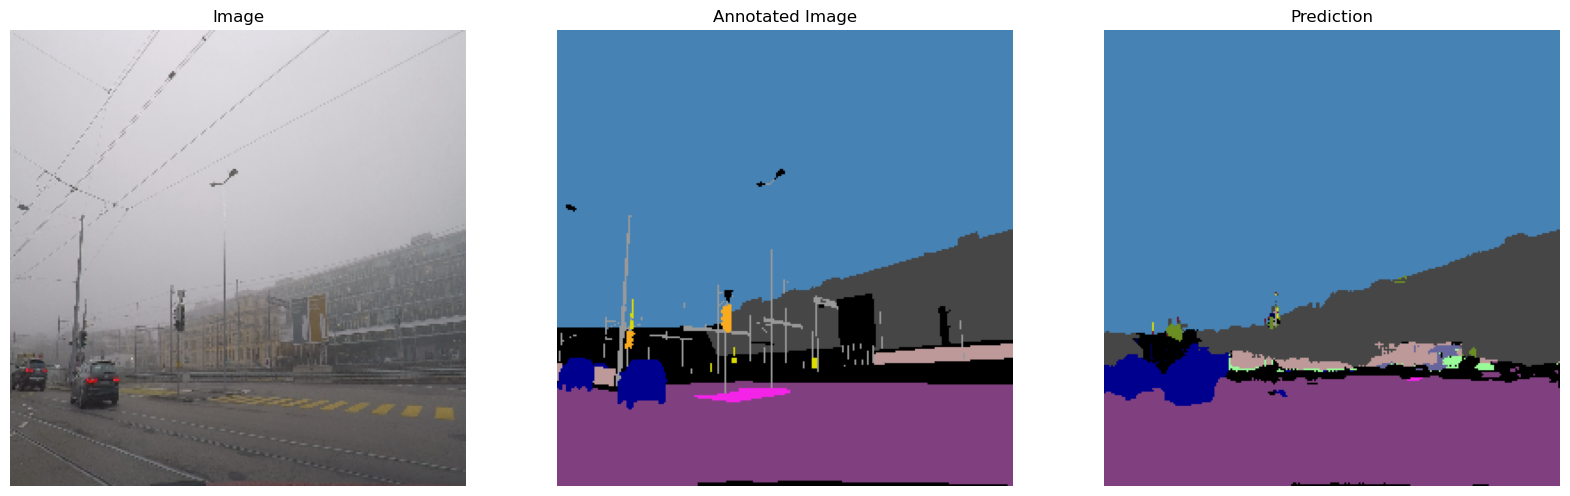

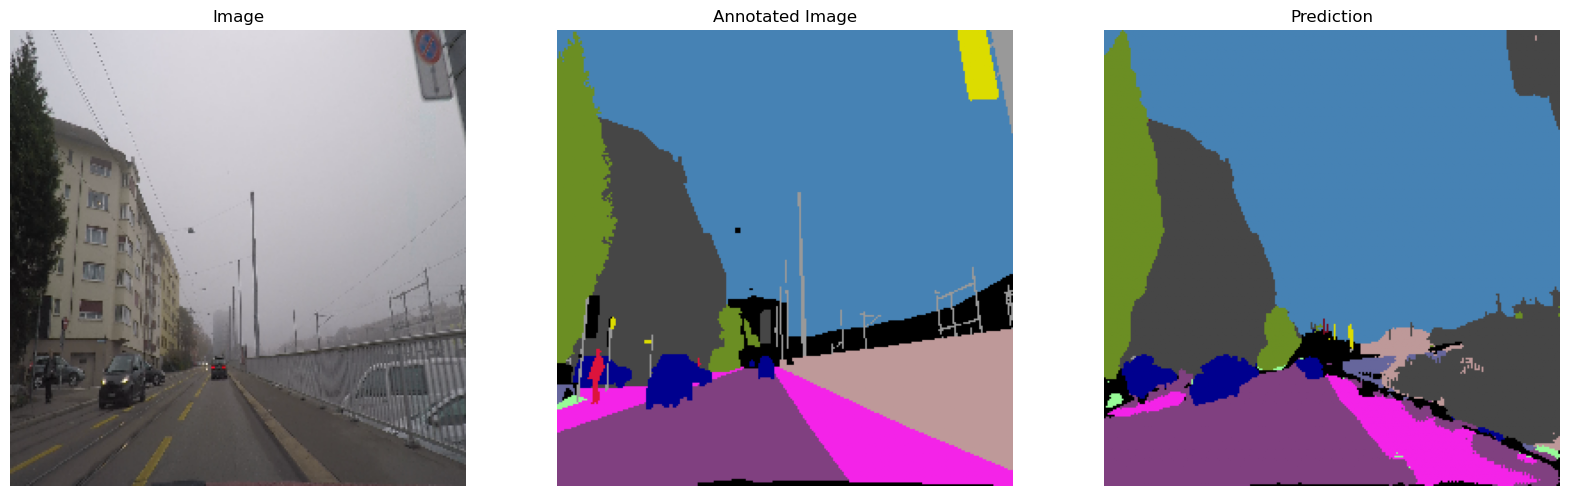

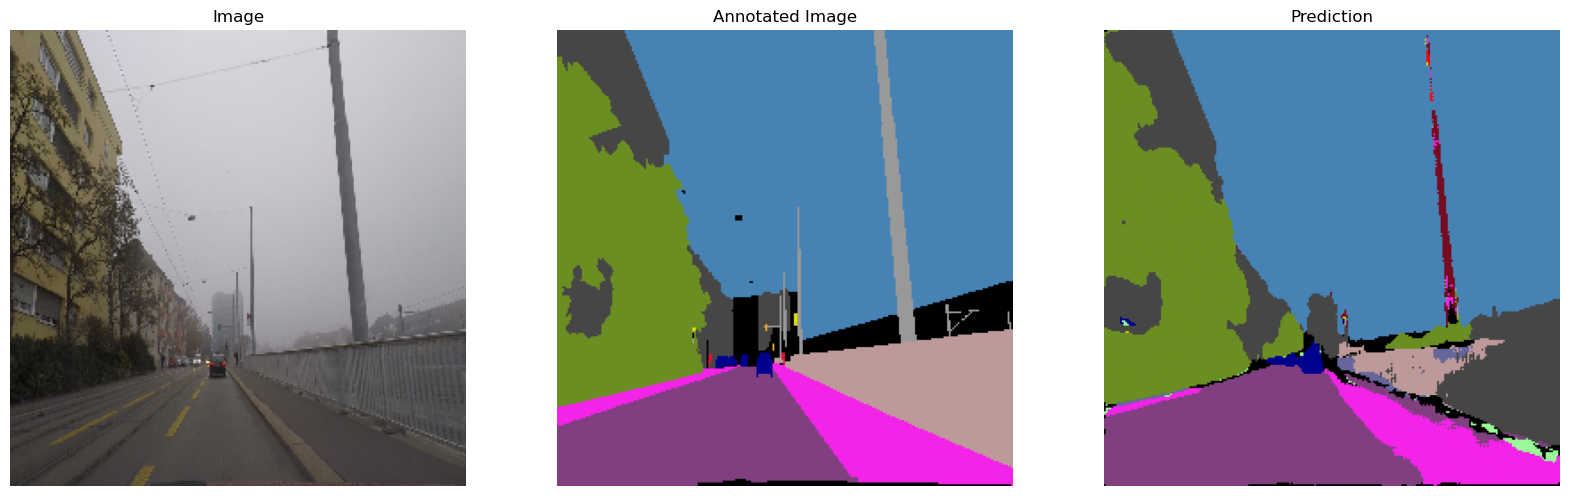

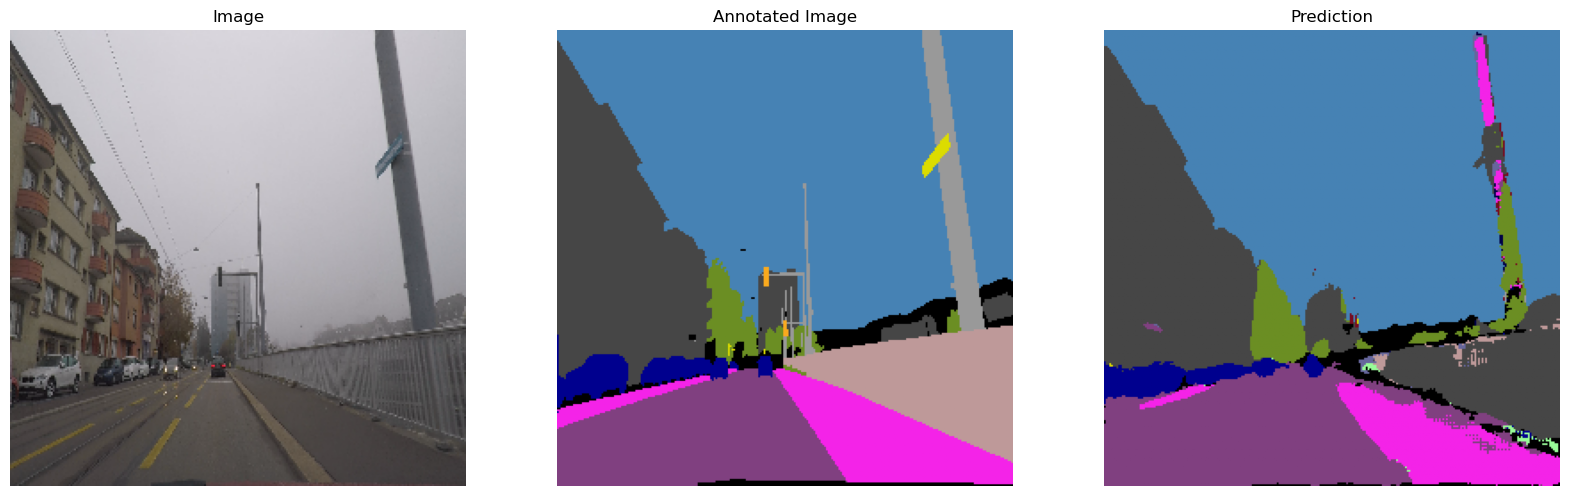

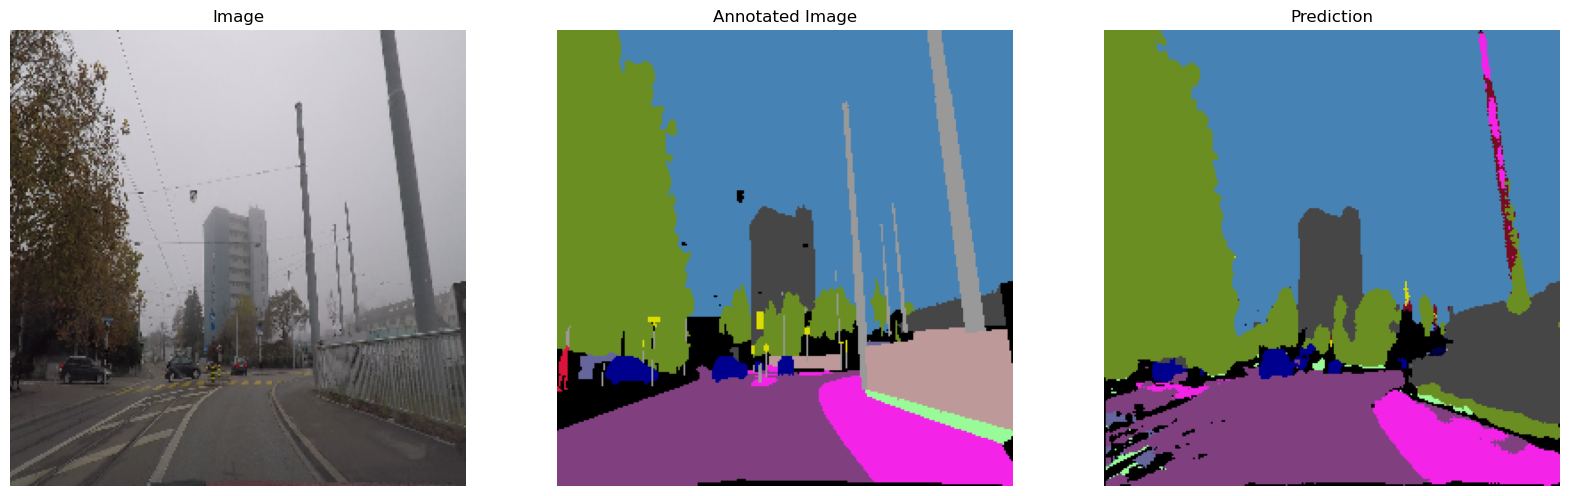

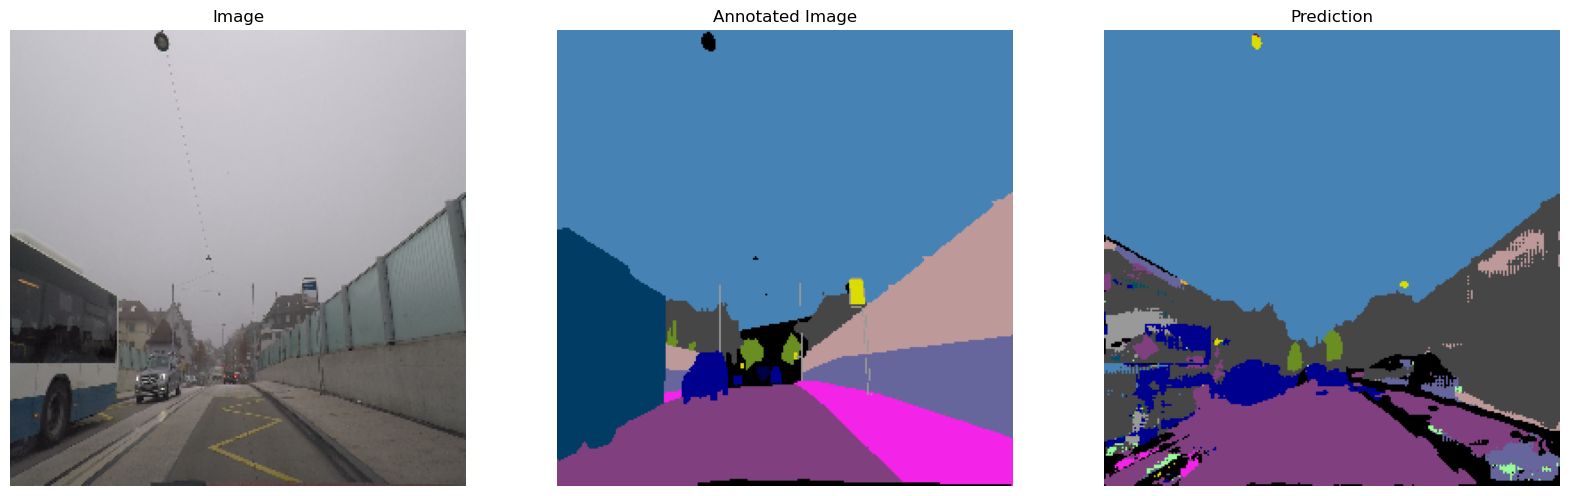

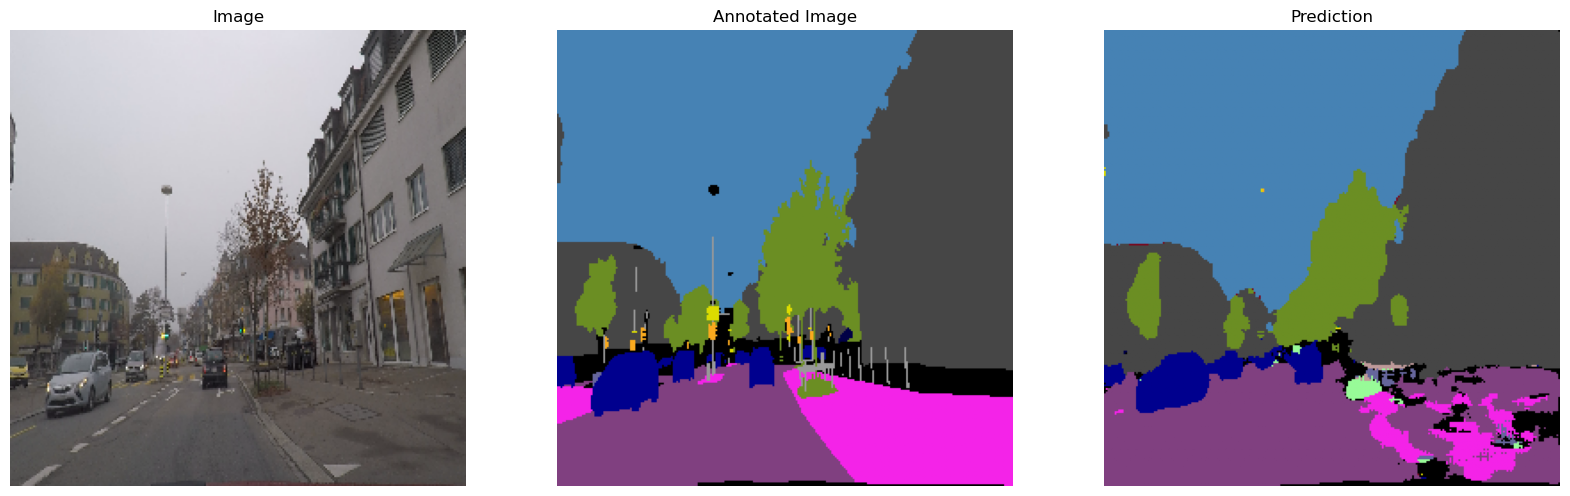

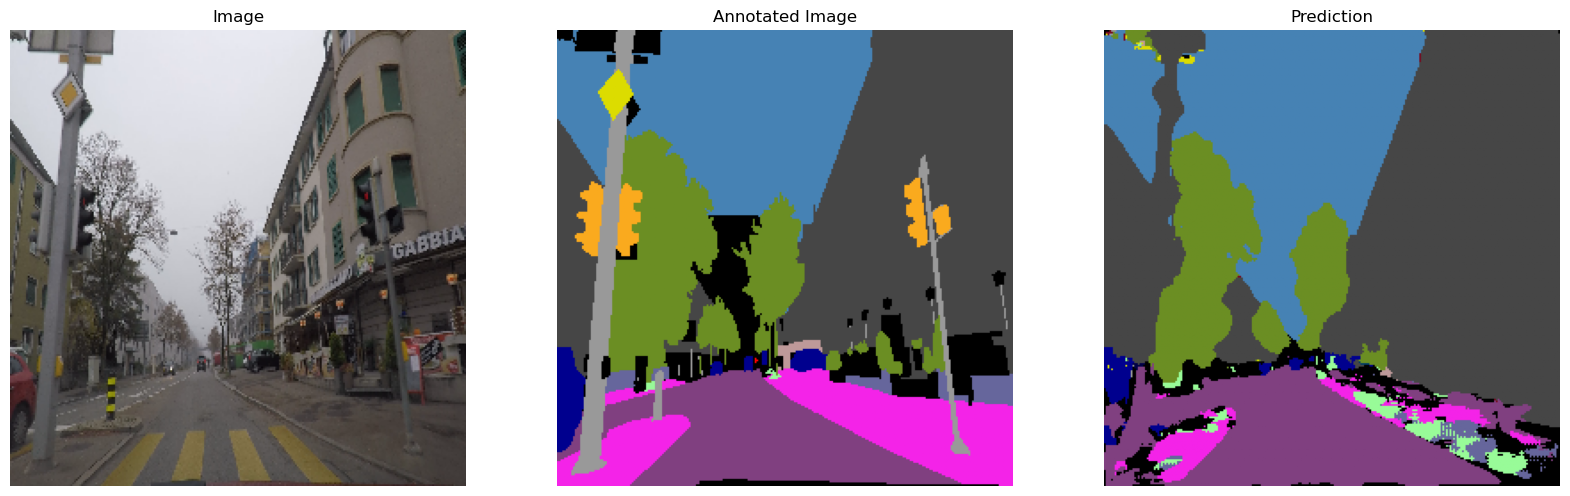

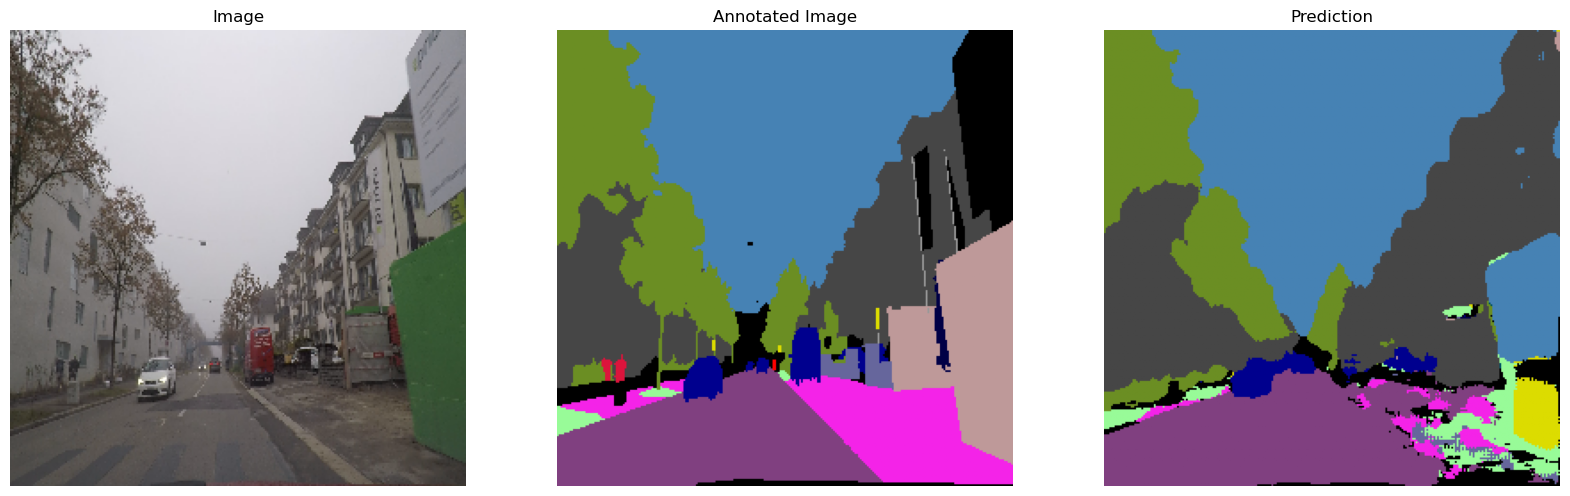

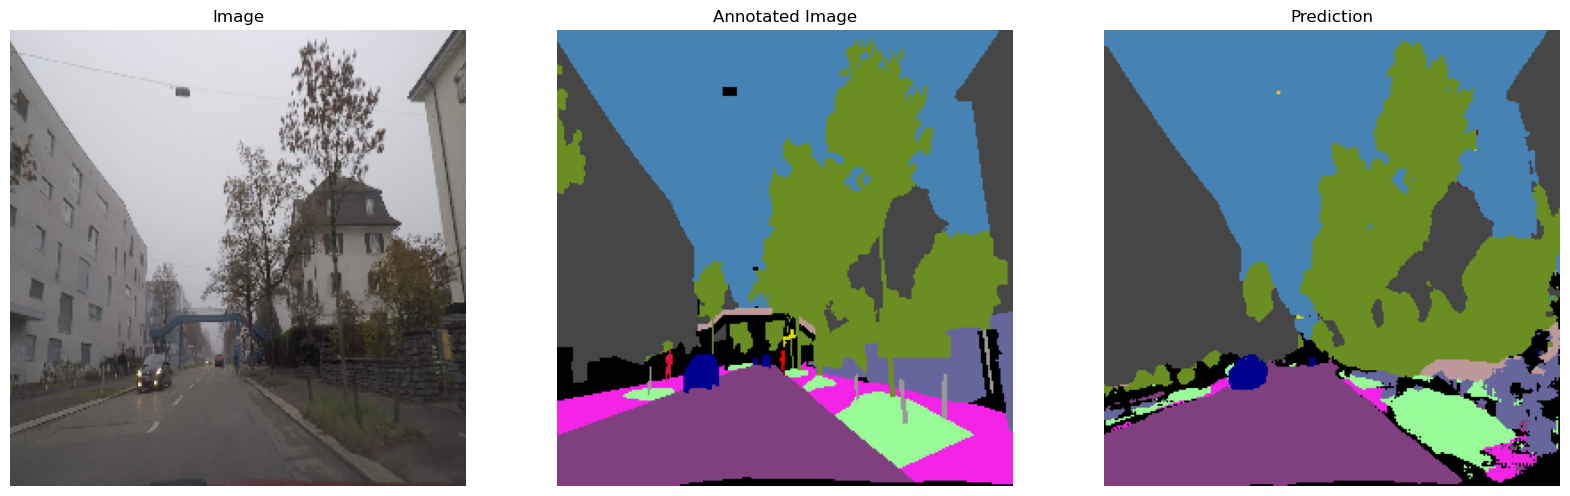

In [44]:
for x in range(0, 10):
    prediction.predict(validation_duo[x])

In [45]:
t = [Path('D:/COMP 597/Project/Dataset/Fog/RGB/Fog_Test/GOPR0477_frame_000798_rgb_anon.png'), Path('D:/COMP 597/Project/Dataset/Fog/RGB/Fog_Test/GOPR0477_frame_000798_rgb_anon.png')]

1/1 [==============================] - 0s 18ms/step


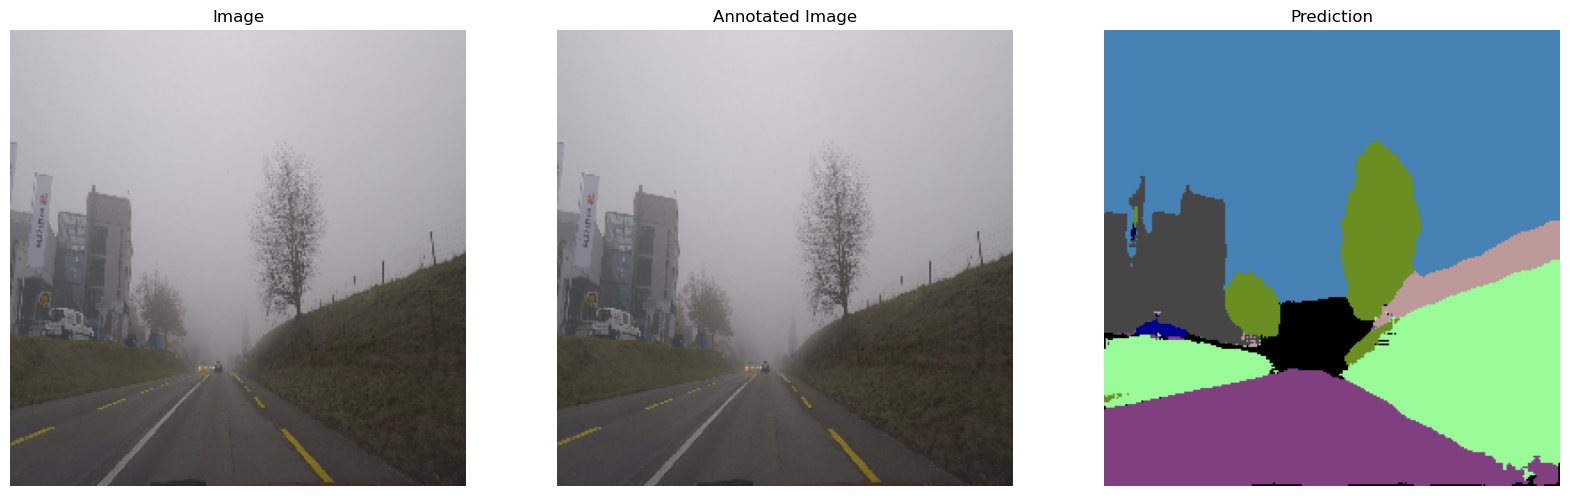

In [46]:
prediction.predict(t)